# Using RL to Model Cognitive Tasks

**By Neurmatch Academy**

__Content creators:__ Morteza Ansarinia, Yamil Vidal

__Production editor:__ Spiros Chavlis


<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective

- This project aims to use behavioral data to train an agent and then use the agent to investigate data produced by human subjects. Having a computational agent that mimics humans in such tests, we will be able to compare its mechanics with human data.

- In another conception, we could fit an agent that learns many cognitive tasks that require abstract-level constructs such as executive functions. This is a multi-task control problem.




---
# Setup

In [1]:
# @title Install dependencies
# !pip install --upgrade pip setuptools wheel --quiet
!pip install dm-acme[jax,tensorflow] --quiet
!pip install dm-acme[envs] --quiet
!pip install dm-sonnet --quiet
!pip install trfl --quiet

     |████████████████████████████████| 314 kB 5.7 MB/s 
     |████████████████████████████████| 3.8 MB 58.3 MB/s 
     |████████████████████████████████| 72 kB 676 kB/s 
     |████████████████████████████████| 342 kB 71.5 MB/s 
     |████████████████████████████████| 202 kB 72.4 MB/s 
     |████████████████████████████████| 145 kB 73.8 MB/s 
     |████████████████████████████████| 117 kB 57.3 MB/s 
     |████████████████████████████████| 6.4 MB 48.0 MB/s 
     |████████████████████████████████| 4.0 MB 46.8 MB/s 
     |████████████████████████████████| 668.3 MB 18 kB/s 
     |████████████████████████████████| 5.7 MB 60.0 MB/s 
     |████████████████████████████████| 462 kB 69.2 MB/s 
     |████████████████████████████████| 9.1 MB 24.4 MB/s 
     |████████████████████████████████| 217 kB 72.5 MB/s 
     |████████████████████████████████| 596 kB 74.2 MB/s 
     |████████████████████████████████| 51 kB 4.7 MB/s 
     |████████████████████████████████| 272 kB 68.0 MB/s 
     |█████████████

In [2]:
# Imports

import time
import numpy as np
import pandas as pd
import sonnet as snt
import seaborn as sns
import matplotlib.pyplot as plt

import dm_env

import acme
from acme import specs
from acme import wrappers
from acme import EnvironmentLoop
from acme.agents.tf import dqn
from acme.utils import loggers
from acme.agents.tf import r2d2
from tqdm import tqdm

In [3]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

---
# Background

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

- Despite an extensive body of research that explains human performance using descriptive what-models, we still need a more sophisticated approach to gain a better understanding of the underlying processes (i.e., a how-model).

- Interestingly, many of such tests can be thought of as a continuous stream of stimuli and corresponding actions, that is in consonant with the RL formulation. In fact, RL itself is in part motivated by how the brain enables goal-directed behaviors using reward systems, making it a good choice to explain human performance.

- One behavioral test example would be the N-back task.

  - In the N-back, participants view a sequence of stimuli, one by one, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedback is given at both timestep and trajectory levels.

  - The agent is rewarded when its response matches the stimulus that was shown N steps back in the episode. A simpler version of the N-back uses two-choice action schema, that is match vs non-match. Once the present stimulus matches the one presented N step back, then the agent is expected to respond to it as being a `match`.


- Given a trained RL agent, we then find correlates of its fitted parameters with the brain mechanisms. The most straightforward composition could be the correlation of model parameters with the brain activities.

## Datasets

- HCP WM task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))

Any dataset that used cognitive tests would work.
Question: limit to behavioral data vs fMRI?
Question: Which stimuli and actions to use?
classic tests can be modeled using 1) bounded symbolic stimuli/actions (e.g., A, B, C), but more sophisticated one would require texts or images (e.g., face vs neutral images in social stroop dataset)
The HCP dataset from NMA-CN contains behavioral and imaging data for 7 cognitive tests including various versions of N-back.

## N-back task

In the N-back task, participants view a sequence of stimuli, one per time, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedbacks are given at both timestep and trajectory levels.

In a typical neuro setup, both accuracy and response time are measured, but here, for the sake of brevity, we focus only on accuracy of responses.

---
# Cognitive Tests Environment

First we develop an environment in that agents perform a cognitive test, here the N-back.

## Human dataset

We need a dataset of human perfoming a N-back test, with the following features:

- `participant_id`: following the BIDS format, it contains a unique identifier for each participant.
- `trial_index`: same as `time_step`.
- `stimulus`: same as `observation`.
- `response`: same as `action`, recorded response by the human subject.
- `expected_response`: correct response.
- `is_correct`: same as `reward`, whether the human subject responded correctly.
- `response_time`: won't be used here.

Here we generate a mock dataset with those features, but remember to **replace this with real human data.**

### Environment

The following cell implments N-back envinronment, that we later use to train a RL agent on human data. It is capable of performing two kinds of simulation:
- rewards the agent once the action was correct (i.e., a normative model of the environment).
- receives human data (or mock data if you prefer), and returns what participants performed as the observation. This is more useful for preference-based RL.

In [19]:
class NBack(dm_env.Environment):

  ACTIONS = ['match', 'non-match']

  def __init__(self,
               N=2,
               episode_steps=32,
               stimuli_choices=list('ABCDEF'),
               human_data=None,
               seed=1,
               prob = None
               ):
    """
    Args:
      N: Number of steps to look back for the matched stimuli. Defaults to 2 (as in 2-back).
      episode_steps
      stimuli_choices
      human_data
      seed

    """
    self.N = N
    self.episode_steps = episode_steps
    self.stimuli_choices = stimuli_choices
    self.stimuli = np.empty(shape=episode_steps)  # will be filled in the `reset()`
    self.n_s = len(self.stimuli_choices)
    if prob is None:
      self.prob = 0.5 * (self.n_s - 2)/ (self.n_s - 1)
    else:
      self.prob = prob
    self._reset_next_step = True

    # whether mimic humans or reward the agent once it responds optimally.
    if human_data is None:
      self._imitate_human = False
      self.human_data = None
      self.human_subject_data = None
    else:
      self._imitate_human = True
      self.human_data = human_data
      self.human_subject_data = None

    self._action_history = []

  def reset(self):
    self._reset_next_step = False
    self._current_step = 0
    self._action_history.clear()

    # generate a random sequence instead of relying on human data
    if self.human_data is None:
      for i in range(self.episode_steps):
          if i<self.N:
            self.stimuli[i]=np.random.choice(self.n_s)
          else:
            rand = np.random.random()
            if rand < self.prob:
              self.stimuli[i]=self.stimuli[i-self.N]
            else:
              self.stimuli[i]=np.random.choice(self.n_s)
    else:
      self.human_subject_data = self.human_data.query('participant_id == participant_id.sample().iloc[0]',
                                                engine='python').sort_values('trial_index')
      self.stimuli = self.human_subject_data['stimulus'].to_list()
      self.stimuli = np.array([ord(s) - ord('A') + 1 for s in self.stimuli]).astype(np.float32)

    return dm_env.restart(self._observation())


  def _episode_return(self):
    if self._imitate_human:
      return np.mean(self.human_subject_data['response'] == self._action_history)
    else:
      return 0.0

  def step(self, action: int):
    if self._reset_next_step:
      return self.reset()

    agent_action = NBack.ACTIONS[action]

    if self._imitate_human:
      human_action = self.human_subject_data['response'].iloc[self._current_step]
      step_reward = 0. if (agent_action == human_action) else -1.
    else:
      expected_action = 'match' if (self.stimuli[self._current_step] == self.stimuli[self._current_step - self.N]) else 'non-match'
      step_reward = 0. if (agent_action == expected_action) else -1.

    self._action_history.append(agent_action)

    self._current_step += 1

    if self._current_step == self.stimuli.shape[0]:
      self._reset_next_step = True
      return dm_env.termination(reward=self._episode_return(),
                                observation=self._observation())
    else:
      return dm_env.transition(reward=step_reward,
                               observation=self._observation())

  def observation_spec(self):
    return dm_env.specs.BoundedArray(
        shape=self.stimuli[0].shape,
        dtype=self.stimuli[0].dtype,
        name='nback_stimuli', minimum=0, maximum=len(self.stimuli_choices) + 1)

  def action_spec(self):
    return dm_env.specs.DiscreteArray(
        num_values=len(NBack.ACTIONS),
        dtype=np.int32,
        name='action')

  def _observation(self):
    if self._current_step ==  self.episode_steps:
      obs = self.stimuli[0]
    else:
      obs = self.stimuli[self._current_step]

    return obs

  def plot_state(self):
    """Display current state of the environment.

     Note: `M` mean `match`, and `.` is a `non-match`.
    """
    stimuli = self.stimuli[:self._current_step - 1]
    actions = ['M' if a=='match' else '.' for a in self._action_history[:self._current_step - 1]]
    return HTML(
        f'<b>Environment ({self.N}-back):</b><br />'
        f'<pre><b>Stimuli:</b> {"".join(map(str,map(int,stimuli)))}</pre>'
        f'<pre><b>Actions:</b> {"".join(actions)}</pre>'
    )

  @staticmethod
  def create_environment(prob = None):
    """Utility function to create a N-back environment and its spec."""

    # Make sure the environment outputs single-precision floats.
    environment = wrappers.SinglePrecisionWrapper(NBack(prob = prob))

    # Grab the spec of the environment.
    environment_spec = specs.make_environment_spec(environment)

    return environment, environment_spec

### Define a random agent

For more information you can refer to NMA-DL W3D2 Basic Reinforcement learning.

In [5]:
class RandomAgent(acme.Actor):

  def __init__(self, environment_spec, action = None):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = environment_spec.actions.num_values
    self.action = action

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    if self.action is not None: 
      return self.action
    return np.random.randint(self._num_actions)

  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):
    """Does not update as the RandomAgent does not learn from data."""
    pass

## Define Learnable Agents

In [20]:
def dqn_make_network(action_spec: specs.DiscreteArray) -> snt.Module:
  return snt.Sequential([
      snt.Flatten(),
      snt.nets.MLP([128, 128, action_spec.num_values]),
  ])

def r2d2_make_network(action_spec: specs.DiscreteArray) -> snt.Module:
  return snt.DeepRNN([
            snt.Flatten(),
            snt.LSTM(hidden_size = 10),
            snt.nets.MLP([128, 128, action_spec.num_values])
            ])

### Get reward distribution and mean reward of the agent

In [7]:
def get_reward_distribution(agent, env, n_episodes = 25000,  episode_length = 32, log_loss = False):
  # main loop
  n_total_steps = 0
  n_steps = n_episodes * episode_length
  all_returns = []
  for episode in range(n_episodes):
    episode_steps = 0
    episode_return = 0
    episode_loss = 0

    start_time = time.time()

    timestep = env.reset()

    # Make the first observation.
    agent.observe_first(timestep)

    # Run an episode
    while not timestep.last():

      # Generate an action from the agent's policy and step the environment.
      action = agent.select_action(timestep.observation)
      timestep = env.step(action)

      # Have the agent observe the timestep and let the agent update itself.
      agent.observe(action, next_timestep=timestep)
      agent.update()

      # Book-keeping.
      episode_steps += 1
      
      n_total_steps += 1
      print(n_total_steps)
      episode_return += timestep.reward

      if log_loss:
        episode_loss += agent.last_loss

      if n_steps is not None and n_total_steps >= n_steps:
        break

    # Collect the results and combine with counts.
    steps_per_second = episode_steps / (time.time() - start_time)
    result = {
        'episode': episode,
        'episode_length': episode_steps,
        'episode_return': episode_return,
    }
    if log_loss:
      result['loss_avg'] = episode_loss/episode_steps

    all_returns.append(episode_return)

    #display(env.plot_state())
    # Log the given results.
    # print(result)

    if n_steps is not None and n_total_steps >= n_steps:
      break

  return all_returns, np.mean(all_returns), np.std(all_returns)

## Training and Evaluation Script

In [8]:
def train_and_eval(env, agent, train , n_episodes,  episode_length, log_loss = False):
  if train:
    print("here")
    loop = EnvironmentLoop(env, agent, logger=loggers.InMemoryLogger())
    loop.run(n_episodes)

    return pd.DataFrame(loop._logger._data)
  
  else:
    all_returns, mean_return, std_return = get_reward_distribution(agent, env, n_episodes = 25000,  episode_length = 32, log_loss = False)
    clear_output()
    print(f'Mean Return: {mean_return} | Standard Deviation: {std_return}')
    plt.figure()
    sns.histplot(all_returns, stat="density", kde=True, bins=12)
    plt.xlabel('Return [a.u.]')
    plt.ylabel('Density')
    plt.show()

    return None

### Initialize the environments

In [21]:
env_balanced, env_spec_balanced = NBack.create_environment()
env_unbalanced, env_spec_unbalanced = NBack.create_environment(prob = 0.)

print('actions:\n', env_spec_balanced.actions)
print('observations:\n', env_spec_balanced.observations)
print('rewards:\n', env_spec_balanced.rewards)

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=1, num_values=2)
observations:
 BoundedArray(shape=(), dtype=dtype('float32'), name='nback_stimuli', minimum=0.0, maximum=7.0)
rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


# Define Agents

In [22]:
random_agent = RandomAgent(env_spec_balanced)
match_agent = RandomAgent(env_spec_balanced, 0)
unmatch_agent = RandomAgent(env_spec_balanced, 1)

dqn_agent_balanced = dqn.DQN(
    environment_spec=env_spec_balanced,
    network=dqn_make_network(env_spec_balanced.actions),
    epsilon=[0.5],
    learning_rate = 0.0001,
    min_replay_size = 32,
    logger=loggers.InMemoryLogger(),
    checkpoint=False,
)

dqn_agent_unbalanced = dqn.DQN(
    environment_spec=env_spec_unbalanced,
    network=dqn_make_network(env_spec_unbalanced.actions),
    epsilon=[0.5],
    learning_rate = 0.0001,
    min_replay_size = 32,
    logger=loggers.InMemoryLogger(),
    checkpoint=False,
)

drqn_agent_balanced = r2d2.R2D2(
    environment_spec=env_spec_balanced,
    network=r2d2_make_network(env_spec_balanced.actions),
    learning_rate = 0.0001,
    burn_in_length=10,
    trace_length=2,
    replay_period=10,
    epsilon=[0.05],
    logger=loggers.InMemoryLogger(),
    min_replay_size = 32,
    checkpoint=False,
)

drqn_agent_unbalanced = r2d2.R2D2(
    environment_spec=env_spec_unbalanced,
    network=r2d2_make_network(env_spec_unbalanced.actions),
    learning_rate = 0.0001,
    burn_in_length=10,
    trace_length=2,
    replay_period=10,
    epsilon=[0.05],
    logger=loggers.InMemoryLogger(),
    min_replay_size = 32,
    checkpoint=False,
)

In [11]:
n_episodes = 25000
episode_length = 32

## Random Agent

### Balanced N-Back

Mean Return: -15.52376 | Standard Deviation: 2.800956169310759


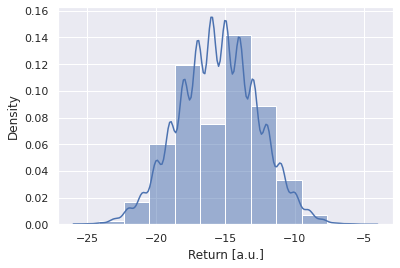

In [12]:
train_and_eval(env_balanced, random_agent, False, n_episodes = n_episodes,  episode_length = episode_length, log_loss = False)

### Un-Balanced N-Back

Mean Return: -15.48716 | Standard Deviation: 2.7800566782711464


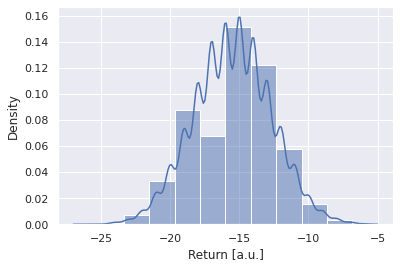

In [13]:
train_and_eval(env_unbalanced, random_agent, False, n_episodes = n_episodes,  episode_length = episode_length, log_loss = False)

## Matching Agent

### Balanced N-Back

Mean Return: -16.18132 | Standard Deviation: 2.74579734459774


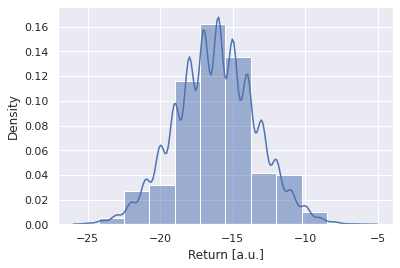

In [14]:
train_and_eval(env_balanced, match_agent,False, n_episodes = n_episodes,  episode_length = episode_length, log_loss = False)

### Un-Balanced N-Back

Mean Return: -25.82692 | Standard Deviation: 2.0930559747890163


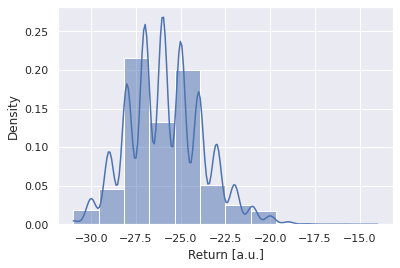

In [15]:
train_and_eval(env_unbalanced, match_agent,False, n_episodes = n_episodes,  episode_length = episode_length, log_loss = False)

## Un-Matching Agent

### Balanced N-Back

Mean Return: -14.8332 | Standard Deviation: 2.754534036820021


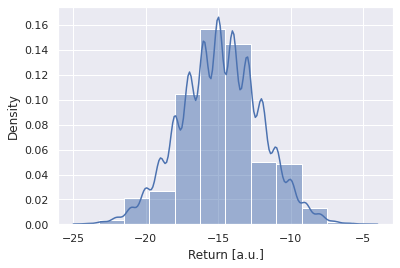

In [16]:
train_and_eval(env_balanced, unmatch_agent, False, n_episodes = n_episodes,  episode_length = episode_length, log_loss = False)

### Un-Balanced N-Back

Mean Return: -5.15156 | Standard Deviation: 2.077081983552888


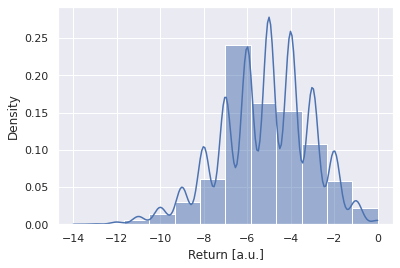

In [17]:
train_and_eval(env_unbalanced, unmatch_agent, False, n_episodes = n_episodes,  episode_length = episode_length, log_loss = False)

## DQN Agent

### Balanced N-Back

In [23]:
logs_dqn_balanced = train_and_eval(env_balanced, dqn_agent_balanced, True, n_episodes = n_episodes,  episode_length = episode_length, log_loss = False)

here


Mean Return: -15.36624 | Standard Deviation: 2.765217579576696


Text(0, 0.5, 'Density')

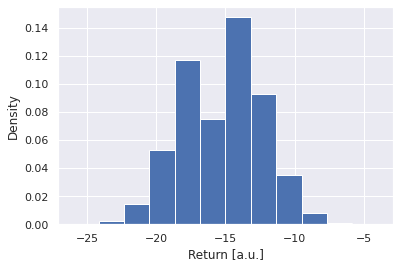

In [24]:
mean_dqn = np.mean(logs_dqn_balanced['episode_return'])
std_dqn = np.std(logs_dqn_balanced['episode_return'])

print(f'Mean Return: {mean_dqn} | Standard Deviation: {std_dqn}')
plot = logs_dqn_balanced.episode_return.hist(bins=12, density=True)
plot.set_xlabel('Return [a.u.]')
plot.set_ylabel('Density')


### Un-Balanced N-Back

In [25]:
logs_dqn_unbalanced = train_and_eval(env_unbalanced, dqn_agent_unbalanced, True, n_episodes = n_episodes,  episode_length = episode_length, log_loss = False)

here


Mean Return: -10.86908 | Standard Deviation: 2.9555270179106805


Text(0, 0.5, 'Density')

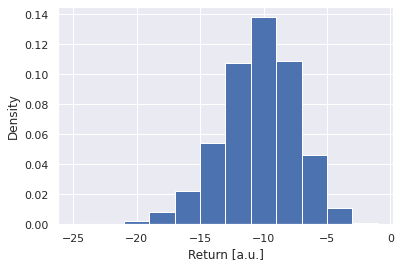

In [26]:
mean_dqn_ub = np.mean(logs_dqn_unbalanced['episode_return'])
std_dqn_ub = np.std(logs_dqn_unbalanced['episode_return'])
print(f'Mean Return: {mean_dqn_ub} | Standard Deviation: {std_dqn_ub}')

plot_dqn_ub = logs_dqn_unbalanced.episode_return.hist(bins=12, density=True)
plot_dqn_ub.set_xlabel('Return [a.u.]')
plot_dqn_ub.set_ylabel('Density')


## DRQN Agent

### Balanced N-Back

In [27]:
logs_drqn_balanced = train_and_eval(env_balanced, drqn_agent_balanced, True, n_episodes = n_episodes,  episode_length = episode_length, log_loss = False)

here
INFO:tensorflow:Assets written to: /root/acme/2d5f4468-0d66-11ed-9aaa-0242ac1c0002/snapshots/network/assets


Mean Return: -12.623 | Standard Deviation: -12.623


,episode_length,episode_return,steps_per_second,episodes,steps
24995,32,-16.0,354.970056,24996,799872
24996,32,-14.0,286.602623,24997,799904
24997,32,-18.0,316.785098,24998,799936
24998,32,-17.0,343.858826,24999,799968
24999,32,-16.0,334.936410,25000,800000


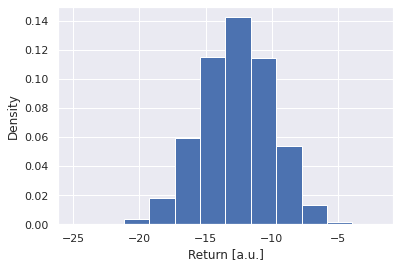

In [28]:
mean_drqn = np.mean(logs_drqn_balanced['episode_return'])
std_drqn = np.std(logs_drqn_balanced['episode_return'])

print(f'Mean Return: {mean_drqn} | Standard Deviation: {mean_drqn}')

plot_drqn = logs_drqn_balanced.episode_return.hist(bins=12, density = True)
plot_drqn.set_xlabel('Return [a.u.]')
plot_drqn.set_ylabel('Density')
logs_dqn_balanced.tail()

### Un-Balanced N-Back

In [29]:
logs_drqn_unbalanced = train_and_eval(env_unbalanced, drqn_agent_unbalanced, True, n_episodes = n_episodes,  episode_length = episode_length, log_loss = False)

here
INFO:tensorflow:Assets written to: /root/acme/2d5f4468-0d66-11ed-9aaa-0242ac1c0002/snapshots/network/assets


Mean Return: -7.64784 | Standard Deviation: -7.64784


,episode_length,episode_return,steps_per_second,episodes,steps
24995,32,-8.0,342.566942,24996,799872
24996,32,-15.0,367.830656,24997,799904
24997,32,-10.0,363.534672,24998,799936
24998,32,-6.0,368.094957,24999,799968
24999,32,-4.0,336.529510,25000,800000


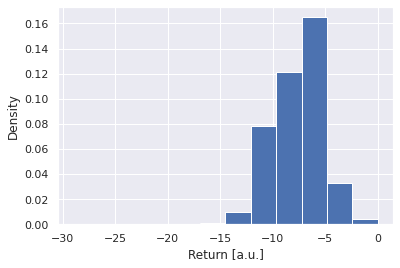

In [30]:
mean_drqn_ub = np.mean(logs_drqn_unbalanced['episode_return'])
std_drqn_ub = np.std(logs_drqn_unbalanced['episode_return'])

print(f'Mean Return: {mean_drqn_ub} | Standard Deviation: {mean_drqn_ub}')

plot_drqn = logs_drqn_unbalanced.episode_return.hist(bins=12, density = True)
plot_drqn.set_xlabel('Return [a.u.]')
plot_drqn.set_ylabel('Density')
logs_drqn_unbalanced.tail()

In [31]:
def moving_average(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'same')  

Text(0.5, 1.0, 'Equal match and non-match')

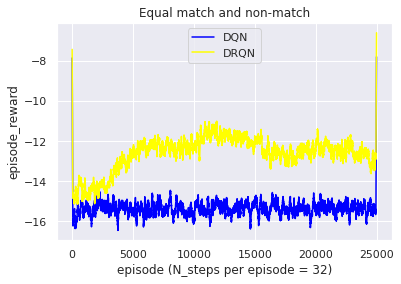

In [32]:
# Balanced Logs
dqn_b_ma = moving_average(logs_dqn_balanced['episode_return'], 100)
drqn_b_ma = moving_average(logs_drqn_balanced['episode_return'], 100)

# dqn_b = list(logs_dqn_balanced['episode_return'])
# drqn_b = list(logs_drqn_balanced['episode_return'])

plt.plot(dqn_b_ma, color='blue')
plt.plot(drqn_b_ma, color='yellow')

# plt.plot(dqn_b, color='blue')
# plt.plot(drqn_b, color='yellow')

plt.ylabel("episode_reward")
plt.xlabel("episode (N_steps per episode = 32)")
plt.legend(['DQN','DRQN'])
plt.title("Equal match and non-match")

Text(0.5, 1.0, 'Unequal match and non-match')

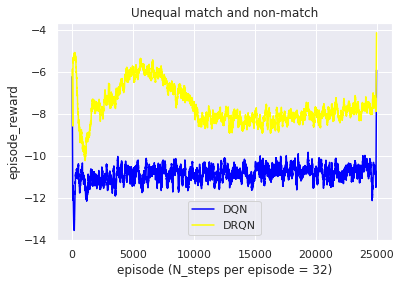

In [33]:
# Un-Balanced Logs
dqn_u_ma = moving_average(logs_dqn_unbalanced['episode_return'], 100)
drqn_u_ma = moving_average(logs_drqn_unbalanced['episode_return'], 100)

# dqn_u = list(logs_dqn_unbalanced['episode_return'])
# drqn_u = list(logs_drqn_unbalanced['episode_return'])

plt.plot(dqn_u_ma, color='blue')
plt.plot(drqn_u_ma, color='yellow')

# plt.plot(dqn_u, color='blue')
# plt.plot(drqn_u, color='yellow')

plt.ylabel("episode_reward")
plt.xlabel("episode (N_steps per episode = 32)")
plt.legend(['DQN','DRQN'])
plt.title("Unequal match and non-match")